# Transformer model (GPT) from scratch

GPT (Not "THE ChatGPT") is a Large Language Model (LLM) made by OpenAI back in 2018. Its architecture is based on the decoder-based transformer model from [Attention Is All You Need](https://arxiv.org/pdf/1706.03762) paper.

- Why a Language Model? -> Bcoz it just predicts and generates the next word for a given input sequence of words.
- Why not "THE ChatGPT"? -> Bcoz its just a text generator, not someone to chat with. ChatGPT is a conversational app built on top of GPT.
- Why Large? -> Bcoz its basically a large neural network with millions (billions for SOTA models) of parameters.

We will rather train a simpler and smaller model of our own.
___

### But why transformers?

Earlier RNN based language models like GRU or LSTM process text word-by-word due to which they faced challenges like:
- long-term memory loss as information from the beginning of a long sentence often fades or gets lost ("vanishing gradient problem") by the time the model reaches the end.
- were very slow to train or infer due to their sequential nature of processing.  

Transformer model solved these problems by leveraging attention mechanism which mathematically is just a matrix multiplication thus allowing parallel processing of entire text sequence at once. This enables self-attention to look at all the words in the sequence at the same time for getting context.
___

### 1. Dataset preparation

Models like GPTs were trained on massive internet data. We will use a simple and tiny dataset which basically consists of Shakespeare literature.

Typical dataset preparation involves **tokenization**. It is the process of splitting a text sequence into samller chunks (like splitting a sentence into words) which are converted to numbers (integers) bcoz neural networks being a mathematical model (doing some matrix multiplications and additions) work with numbers. These numbers (or tokens) are what a language model takes as input and generates as output. Thus we  need to encode the text sequences into list of tokens for the input and decode the predicted tokens back to original text sequence for the textoutput.

Tokenization itself is a hell of a process. Modern tokenization techniques use BPE (Byte Pair Encoding) algorithm which iteratively merges the most frequently occurring pairs of characters or bytes into new, single units producing sub-word tokens e.g. "ing", "ment", "er", etc.

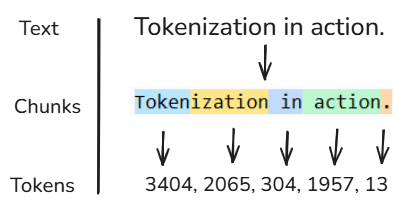

Want to see it live, just click here 👉 [Tiktokenizer](https://tiktokenizer.vercel.app/).

We will instead follow a simple tokenization process where we tokenize each character. Thus every unique character in the dataset will be considered as a single token. Thus our model will work with character-level tokens and once trained it will generate text character-by-character but in Shakespeare style.

#### 1.1 Loading dataset

In [1]:
with open("data/tiny_shakespeare.txt", encoding="utf-8") as f:
    text = f.read()

print(text[:1000]) # first 1000 characters

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [2]:
len(text) # 1M+ character-level tokens

1115394

#### 1.2 Creating vocabulary

In [3]:
chars = sorted(set(''.join(text))) # getting all unique characters
vocab_size = len(chars) # total unique characters/tokens
print(chars)
print(vocab_size)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
65


#### 1.3 Creating encoder and decoder

In [4]:
# character to integer mappings
ch_to_i = {ch: i for i, ch in enumerate(chars)}
i_to_ch = {i: ch for i, ch in enumerate(chars)}
print(ch_to_i)
print(i_to_ch)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i',

In [5]:
# defining encoder and docoder
encode = lambda str: [ch_to_i[ch] for ch in str] # takes a string -> returns list of integers/tokens
decode = lambda ints: ''.join(i_to_ch[i] for i in ints) # takes a list of integers/tokens -> returns a string

# testing
decode(encode("Hello World!")) # YEH! it works.

'Hello World!'

#### 1.4 Converting tokens to a PyTorch tensor object

Why tensor object? -> Bcoz models created using PyTorch use tensors as datatypes which not only store data but also store the gradients required for training optimization.

***Note:** Here we are using `torch.long` data type for our tensor object. This is required in order to index embeddings from the embedding matrix that we will use later.*

In [6]:
import torch

# encode text to tokens and store into a torch.tensor object
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
data[:100] # first 100 tokens

torch.Size([1115394]) torch.int64


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])

In [7]:
print(f"First 10 characters (original): {text[:10]}")
print(f"First 10 characters (tokenized): {data[:10].tolist()}")
print("Character to token mapping:")
for ch in list(text[:10]):
    print(f"char = '{ch}' | token = {ch_to_i[ch]}")

First 10 characters (original): First Citi
First 10 characters (tokenized): [18, 47, 56, 57, 58, 1, 15, 47, 58, 47]
Character to token mapping:
char = 'F' | token = 18
char = 'i' | token = 47
char = 'r' | token = 56
char = 's' | token = 57
char = 't' | token = 58
char = ' ' | token = 1
char = 'C' | token = 15
char = 'i' | token = 47
char = 't' | token = 58
char = 'i' | token = 47


#### 1.5 Spitting dataset

We use 90% of our data for training (to tune model parameters) and 10% for validation (to tune hyperparameters).

In [8]:
# splitting data into training & validation sets
n = int(0.9 * len(data))
train_data = data[:n] # 90% of data for training
val_data = data[n:] # 10% of data for validation

#### 1.6 Defining context length

Context length is the maximum no. tokens given as input to the model. Larger context length allows more tokens to be fed into the model thus the model can have more context while predicting next token.

It is a hyperparameter, means its value needs to be emperically set to tune model performance.

We will start with a context length of 8. This means that for the given 8 characters (or tokens as we are using character level tokens) as input our model will predict the 9th token as output. We can gradually scale it up once we are confident of our model implementation.

In [9]:
# defining context length
block_size = 8
train_data[:block_size+1] # block size is the max input sequence, +1 is the target

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

Training on all 8 individual examples is not only efficient but also helps the model adapt to predicting output during inference for the given input sequence of any length between 1 to block size.

#### 1.7 Visualising input sequence and targets

In [10]:
# Visualizing 8 individual examples packed within the sequence of 9 characters as raw text
x = text[:block_size] # inputs
y = text[1:block_size+1] # targets
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is '{context}' the target is '{target}'")

when input is 'F' the target is 'i'
when input is 'Fi' the target is 'r'
when input is 'Fir' the target is 's'
when input is 'Firs' the target is 't'
when input is 'First' the target is ' '
when input is 'First ' the target is 'C'
when input is 'First C' the target is 'i'
when input is 'First Ci' the target is 't'


In [11]:
# Visualizing 8 individual examples packed within the sequence of 9 characters as tokens
x = train_data[:block_size] # inputs
y = train_data[1:block_size+1] # targets
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context.tolist()} the target is {target}")

when input is [18] the target is 47
when input is [18, 47] the target is 56
when input is [18, 47, 56] the target is 57
when input is [18, 47, 56, 57] the target is 58
when input is [18, 47, 56, 57, 58] the target is 1
when input is [18, 47, 56, 57, 58, 1] the target is 15
when input is [18, 47, 56, 57, 58, 1, 15] the target is 47
when input is [18, 47, 56, 57, 58, 1, 15, 47] the target is 58


#### 1.8 Creating batches

Why batches? Training on entire dataset at once can be extremely slow especially if the model is too large (compute intensive).   Instead training on random subsets of data is faster.

A single batch contains ***batch size*** no. of example sequences each with `context length = block size` stacked up together into a tensor. Each sequence in the batch will be processed parallelly by the GPU. Each sequence contains 8 individual examples.

So for `batch size = 4` and `block size = 8`, there are 32 examples.

In [12]:
# creating batches
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for making a prediction?
device = 'cuda' if torch.cuda.is_available() else 'cpu' # use gpu if available

print(f"device = {device}")

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)-block_size, size=(batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[(i+1):(i+1)+block_size] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

xb, yb = get_batch('train')
print("inputs:")
print(xb.shape)
print(xb)
print("targets:")
print(yb.shape)
print(yb)
for b in range(batch_size):
    print("--------------------------------------------------------------")
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target is {target}")

device = cuda
inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]], device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]], device='cuda:0')
--------------------------------------------------------------
when input is [24] the target is 43
when input is [24, 43] the target is 58
when input is [24, 43, 58] the target is 5
when input is [24, 43, 58, 5] the target is 57
when input is [24, 43, 58, 5, 57] the target is 1
when input is [24, 43, 58, 5, 57, 1] the target is 46
when input is [24, 43, 58, 5, 57, 1, 46] the target is 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target is 39
--------------------------------------------------------------
when input is [44] the target is 53
when in

___
### 2. Bigram model

We will first start with super simple bigram langauge model that uses a lookup table to get the **logits** *(raw model outputs on which we will apply softmax to get probability distribution)* for making a prediction.

> A bigram langauge model basically predicts the next char/word in a sequence only on the the basis of last char/word. Basically it just looks at the very last char/word of the sequence to get context when making predictions for the next char/word.

A character-level bigram language model usually counts the frequencies for all possible character pairs from the dataset and store into a counts table like below:
| |a|b|c|...|z|
|-|-|-|-| - |-|
|a|2|13|4|...|0|
|b|24|7|1|...|0|
|c|5|5|0|...|2|
|...|...|...|...|...|...|
|z|5|0|1|...|1|

with each cell having the count for character pairs. For any input character the model just gets the whole row to get frequency counts for all possible pairs starting with that input character. Then the model just calculates probabilities from those counts and select a next character.

Since we are using neural networks, instead of counting and storing character pair frequencies into a table we will use a simple lookup table (or embedding matrix) of same dimensions and expect its parameters to learn the values similar to the count values during training.

This model will serve as the baseline for our transformer model.

#### 2.1 Defining code structure

We will use Pytorch `nn.Module` to define our language model class. Our class will have 3 methods:
1. `__init__` method: to initialize the module parameters
2. `forward` method: which will take the inputs and return the logits and the loss
3. `generate` method: to generate new tokens for the max limit

The implementation of the ***generate*** method in this model seems irrelevant as its taking a sequence of tokens within a batch as input but only the last token in the sequence is being used for the prediction. Its intuitive that a bigram model only needs a single input token to predict the next token but here its taking a sequence of tokens. This is done with a purpose to have a similar implementation of the method for the later transformer model which will consider the history of tokens instead of just the last token to predict the next token in the sequence.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)

class BasicGPT(nn.Module):
	def __init__(self):
		super().__init__()
		# each token directly reads off the logits for the next token from a lookup table
		self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

	def forward(self, idx, targets=None):
		# idx (inputs) and targets are both (B, T) tensor of integers
		logits = self.token_embedding_table(idx) # (B, T, C)
		loss = None
		if targets is not None:
			# Re-shaping is required to conform dimensions for calculating F.cross_entropy
			B, T, C = logits.shape
			logits = logits.view(B*T, C)
			targets = targets.view(B*T)
			loss = F.cross_entropy(logits, targets)
		return logits, loss

	def generate(self, idx, max_new_tokens):
		# idx (inputs) is of shape (B, T)
		for _ in range(max_new_tokens):
			# get predictions
			logits, loss = self(idx) # (B, T, C)
			# focus only on the last time step or the last value in the sequence within the batch
			logits = logits[:, -1, :] # becomes (B, C)
			# apply softmax to get probabilities along the last dim i.e. C
			probs = F.softmax(logits, dim=-1) # (B, C)
			# sample from the distribution to get next prediction in the sequence
			idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
			# append sampled index to the running sequence
			idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

		return idx


model = BasicGPT().to(device)
logits, loss = model(xb, yb)
print(logits.shape)

torch.Size([32, 65])


___
Inputs have the shape of (B, T) containing B*T individual examples.

Logits have shape of (B, T, C) where B represents the batch dimension, T represents the time/sequence dimension and C represents the no. of channels or classes.

For the given dimension values:  
B = batch_size = 4,  
T = block_size = 8,  
C = vocab_size = 65  

**Original:**
logits.shape = [4, 8, 65]  
**After reshaping (during loss calulation):**
logits.shape = [32, 65]  

In the `generate` method, the logits shape is (B, T, C) but since we are predicting next token based on the logits given by last token only, the shape changes to (B, C).

For every batch out of 4 batches, for last token in the sequence -> take the all 65 logits (or embeddings since we are directly indexing them from the table as of now):  
b1 [t1, t2, t3, t4, t5, t6, t7, `t8`]  
b2 [t1, t2, t3, t4, t5, t6, t7, `t8`]  
b3 [t1, t2, t3, t4, t5, t6, t7, `t8`]  
b4 [t1, t2, t3, t4, t5, t6, t7, `t8`]  
where `t8` has 65 values corresponding to each character in the vocabulary. Thus the shape changes to (B, C).

***Note:** Even though we are providing 8 tokens as context still our prediction is solely based on the logits given by last token becoz there is no shared context or no communication is happening among the tokens as of now. Every token is independently indexing its own set of logits directly from the embedding matrix. Thus the logits produced for the last token got the context for only that token.*
___

In [14]:
probs = F.softmax(logits, dim=-1)
observed_mean_prob = probs[torch.arange(32), yb.view(-1)].mean()

print(f"Expected probability: {1/65}")
print(f"Observed probability: {observed_mean_prob}")
print("Expected initial loss:", -torch.log(torch.tensor(1/65)).item())
print("Observed initial loss:", loss.item())

Expected probability: 0.015384615384615385
Observed probability: 0.01053521316498518
Expected initial loss: 4.174387454986572
Observed initial loss: 4.878634929656982


In [15]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
output = decode(model.generate(context, max_new_tokens=100)[0].tolist())
print(f"Text generation at random model params (no training):{output}")

Text generation at random model params (no training):
pYCXxfRkRZd
wc'wfNfT;OLlTEeC K
jxqPToTb?bXAUG:C-SGJO-33SM:C?YI3a
hs:LVXJFhXeNuwqhObxZ.tSVrddXlaSZaNe


___
**Generation:** As of now the model generates gibberish bcoz the model is just randomly initialized. The model needs to learn to align its neurons in a sematically correct way in order to make any sensible output. This will improve after training.
___

#### 2.2 Training our bigram model

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)

# hyperparameters
batch_size = 32
block_size = 8
learning_rate = 1e-2
max_iters = 3000
eval_interval = 300
eval_iters = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"device = {device}")

# loading text data
with open('data/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
	text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(set(text))
vocab_size = len(chars)

# create character to integer / integer to character mappings
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# encoding entire datset and storing it into a torch.tensor
data = torch.tensor(encode(text), dtype=torch.long)

# Splitting data in training and validation sets
n = int(0.9*len(data)) # first 90% of data is for training, rest is for validation
train_data = data[:n]
val_data = data[n:]

# create batches
def get_batch(split):
	data = train_data if split == 'train' else val_data
	ix = torch.randint(len(data)-block_size, size=(batch_size,))
	x = torch.stack([data[i:i+block_size] for i in ix])
	y = torch.stack([data[(i+1):(i+1)+block_size] for i in ix])
	x, y = x.to(device), y.to(device)
	return x, y


class BasicGPT(nn.Module):
	def __init__(self):
		super().__init__()
		# each token directly reads off the logits for the next token from a lookup table
		self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

	def forward(self, idx, targets=None):
		# idx (inputs) and targets are both (B, T) tensor of integers
		logits = self.token_embedding_table(idx) # (B, T, C)
		loss = None
		if targets is not None:
			# Re-shaping is required to conform dimensions for calculating F.cross_entropy
			B, T, C = logits.shape
			logits = logits.view(B*T, C)
			targets = targets.view(B*T)
			loss = F.cross_entropy(logits, targets)
		return logits, loss

	def generate(self, idx, max_new_tokens):
		# idx (inputs) is of shape (B, T)
		for _ in range(max_new_tokens):
			# get predictions
			logits, loss = self(idx) # (B, T, C)
			# focus only on the last time step or the last value in the sequence within the batch
			logits = logits[:, -1, :] # becomes (B, C)
			# apply softmax to get probabilities along the last dim i.e. C
			probs = F.softmax(logits, dim=-1) # (B, C)
			# sample from the distribution to get next prediction in the sequence
			idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
			# append sampled index to the running sequence
			idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

		return idx


model = BasicGPT().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

@torch.no_grad()
def estimate_loss():
	out = {}
	model.eval()
	for split in ['train', 'val']:
		losses = torch.zeros(eval_iters)
		for k in range(eval_iters):
			xb, yb = get_batch(split)
			logits, loss = model(xb, yb)
			losses[k] = loss.item()
		out[split] = losses.mean()
	model.train()
	return out


for iter in range(max_iters):
	 # every once in a while evaluate loss on train and val sets
	if iter % eval_interval == 0:
		losses = estimate_loss()
		print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

	# sample a batch
	xb, yb = get_batch('train')
	# forward pass
	logits, loss = model(xb, yb)
	# set gradients to None
	optimizer.zero_grad(set_to_none=True)
	# backward pass
	loss.backward()
	# update
	optimizer.step()

losses = estimate_loss()
print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

# generate from the model
print("\n------------------------------- GENERATION -------------------------------\n")
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

device = cuda
step 0: train loss 4.7305, val loss 4.7241
step 300: train loss 2.8110, val loss 2.8249
step 600: train loss 2.5434, val loss 2.5682
step 900: train loss 2.4932, val loss 2.5088
step 1200: train loss 2.4863, val loss 2.5035
step 1500: train loss 2.4665, val loss 2.4921
step 1800: train loss 2.4683, val loss 2.4936
step 2100: train loss 2.4696, val loss 2.4846
step 2400: train loss 2.4638, val loss 2.4879
step 2700: train loss 2.4738, val loss 2.4911
step 2999: train loss 2.4613, val loss 2.4897

------------------------------- GENERATION -------------------------------




CEThik brid owindakis b, bth

HAPet bobe d e.
S:
O:3 my d?
LUCous:
Wanthar u qur, t.
War dXENDoate awice my.

Hastarom oroup
Yowhthetof isth ble mil ndill, ath iree sengmin lat Heriliovets, and Win nghir.
Swanousel lind me l.
HAshe ce hiry:
Supr aisspllw y.
Hentofu n Boopetelaves
MPOLI s, d mothakleo Windo whth eisbyo the m dourive we higend t so mower; te

AN ad nterupt f s ar igr t m:

Thin maleronth,

#### 2.3 Baseline results

**final loss:** train loss 2.4613, val loss 2.4897

This is our baseline loss. We will try to surpass this loss with our transformer based implementation.